In [3]:
%load_ext autoreload
%autoreload 2
import copy
from stingray import EventList, AveragedPowerspectrum, AveragedCrossspectrum, Powerspectrum, LombScarglePowerspectrum

import matplotlib.pyplot as plt
import numpy as np

ev1 = EventList.read("nustar_A_src.evt", fmt="ogip")
ev2 = EventList.read("nustar_B_src.evt", fmt="ogip")

ev_tot = ev1.join(ev2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: 'nustar_A_src.evt'

# Observations with frequent data gaps

Many X-ray missions are in low-Earth orbits, which means that their target is often occulted by the Earth. Additionally, these satellites can pass through the South-Atlantic Anomaly, where the flux of particles increases the background (and, in some cases, might even damage the detector, so the Science Operations centers often just switch the instruments off for protection).

This observation of an accreting black hole is an example. Here, transparent red stripes indicate occultation and other bad-data time intervals, while data in good time intervals are plotted in blue:

In [2]:
lc_10 = ev_tot.to_lc(dt=10)
plt.plot(lc_10.time - lc_10.time[0], lc_10.counts, color="grey")
lc_10.apply_gtis(inplace=True)
plt.plot(lc_10.time - lc_10.time[0], lc_10.counts)

plt.xlabel("Time (s)")
plt.ylabel("Counts")

for g0, g1 in zip(lc_10.gti[:-1], lc_10.gti[1:]):
    plt.axvspan(g0[1] - lc_10.time[0], g1[0] - lc_10.time[0], color="r", alpha=0.5, zorder=10)


NameError: name 'ev_tot' is not defined

When we study the variability of this light curve, we usually use periodograms. It is well known that these gaps are like square windows, whose Fourier transform has infinite harmonics, and that gets convolved with the actual variability of the data. If we were to ignore the good time intervals and just get a `Periodogram` of the dataset, we would get something like this (the black vertical line indicates the orbital period of the satellite and some of its harmonics):

In [3]:
ev_tot_dirty = copy.deepcopy(ev_tot)
ev_tot_dirty.gti = np.asarray([[ev_tot.gti[0, 0], ev_tot.gti[-1, 1]]])
pds_dirty = Powerspectrum.from_events(ev_tot_dirty, dt=0.01, norm="leahy")
pds_dirty_reb = pds_dirty.rebin_log(0.01)


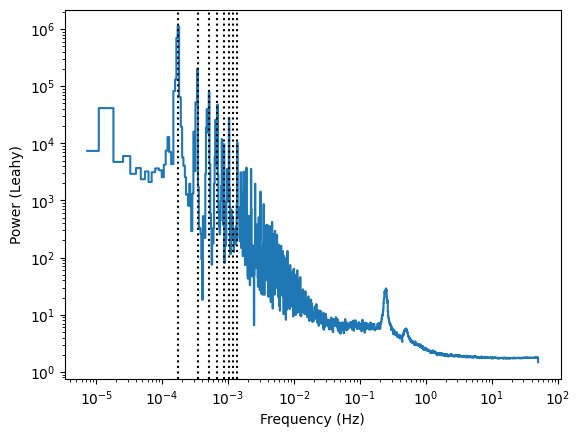

In [4]:
plt.loglog(pds_dirty_reb.freq, pds_dirty_reb.power, drawstyle="steps-mid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (Leahy)")
for i in range(1, 9):
    plt.axvline(i / 97 / 60, ls=":", color="k")

In [2]:
plt.semilogy(pds_dirty_reb.freq, pds_dirty_reb.power, drawstyle="steps-mid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (Leahy)")
for i in range(1, 30):
    plt.axvline(i / 97 / 60, ls=":", color="k")
plt.xlim([5e-5, 5e-3])

NameError: name 'plt' is not defined

Yes, we do see a nice QPO there, but how can we be sure about the low-frequency continuum when it's so polluted from the harmonics of the observing window?

A proper treatment of gaps is not possible at these long timescales, but gaps can certainly be ignored at shorter time scales. As we've seen in the `AveragedPowerspectrum` tutorial, we can study the short-term variability with

In [1]:
pds = AveragedPowerspectrum(ev_tot, dt=0.01, segment_size=256, norm="leahy")
pds_reb = pds.rebin_log(0.01)

NameError: name 'AveragedPowerspectrum' is not defined

In [4]:
plt.loglog(pds_dirty_reb.freq, pds_dirty_reb.power, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.loglog(pds_reb.freq, pds_reb.power, drawstyle="steps-mid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (Leahy)")
for i in range(1, 6):
    plt.axvline(i / 97 / 60, ls=":", color="k")

NameError: name 'pds_dirty_reb' is not defined

Note that, while the "clean" and "dirty" periodograms at high frequencies mostly match, at low frequencies the two diverge. The low-frequency periodogram cannot be trusted if one does not use some trick to avoid the gaps. 

# The Lomb-Scargle periodogram

Fortunately, a method exists and is called the *Lomb Scargle periodogram* ([See this review from Jake Van Der Plas](https://iopscience.iop.org/article/10.3847/1538-4365/aab766/pdf))

The method is slower than the standard periodogram, so we will limit its usage to the interesting frequency range.

In [8]:
maxfreq = 1.
dt = 0.5 / maxfreq  # Using the Nyquist limit
ls = LombScarglePowerspectrum(ev_tot, dt=dt, max_freq=maxfreq, norm="leahy")
ls_reb = ls.rebin_log(0.02)


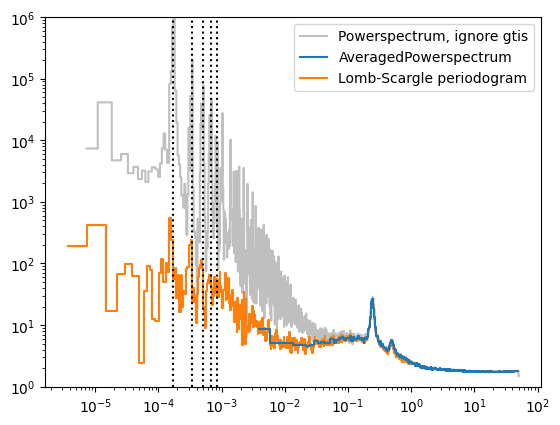

In [9]:
plt.plot(pds_dirty_reb.freq, pds_dirty_reb.power, alpha=0.5, ds="steps-mid", label="Powerspectrum, ignore gtis", color="grey")
plt.plot(pds_reb.freq, pds_reb.power, ds="steps-mid", label="AveragedPowerspectrum", zorder=10)
plt.plot(ls_reb.freq, ls_reb.power, ds="steps-mid", label="Lomb-Scargle periodogram")

plt.loglog()
plt.ylim([1, 1e6])
plt.legend(loc="upper right")
for i in range(1, 6):
    plt.axvline(i / 97 / 60, ls=":", color="k")

Now we're talking! The Lomb-Scargle periodogram nicely connects to the low-frequency part of the periodogram. Now, we can try to model the low-frequency continuum more confidently. 

(5e-05, 0.003)

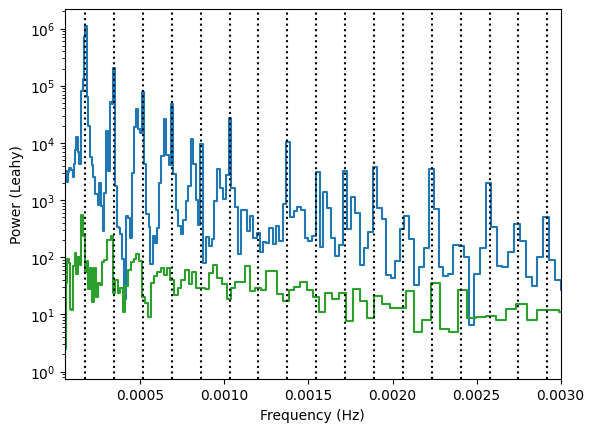

In [10]:
plt.semilogy(pds_dirty_reb.freq, pds_dirty_reb.power, drawstyle="steps-mid")
plt.plot(pds_reb.freq, pds_reb.power, ds="steps-mid", label="AveragedPowerspectrum", zorder=10)
plt.plot(ls_reb.freq, ls_reb.power, ds="steps-mid", label="Lomb-Scargle periodogram")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (Leahy)")
for i in range(1, 30):
    plt.axvline(i / 97 / 60, ls=":", color="k")
plt.xlim([5e-5, 3e-3])

We might still expect to detect the satellite orbital time scale in the periodogram, due to the imperfect frequency response during the orbit, but it's a lower-order problem now.

Looking into more detail, the two curves do not exactly match, in particular close to the maximum frequency:

(1.0, 10.0)

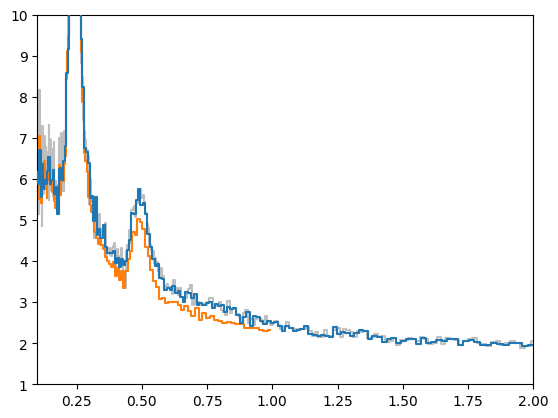

In [11]:
plt.plot(pds_dirty_reb.freq, pds_dirty_reb.power, alpha=0.5, ds="steps-mid", label="Powerspectrum, ignore gtis", color="grey")
plt.plot(pds_reb.freq, pds_reb.power, ds="steps-mid", label="AveragedPowerspectrum", zorder=10)
plt.plot(ls_reb.freq, ls_reb.power, ds="steps-mid", label="Lomb-Scargle periodogram")
plt.xlim([0.1, 2])
plt.ylim([1, 10])

That little "wiggle" happens somewhere between 0.5 and 1 times the "Nyquist" frequency when data are mostly evenly sampled as in our case. The solution is simply to use a smaller sampling time while maintaining the same maximum frequency.

(1.0, 10.0)

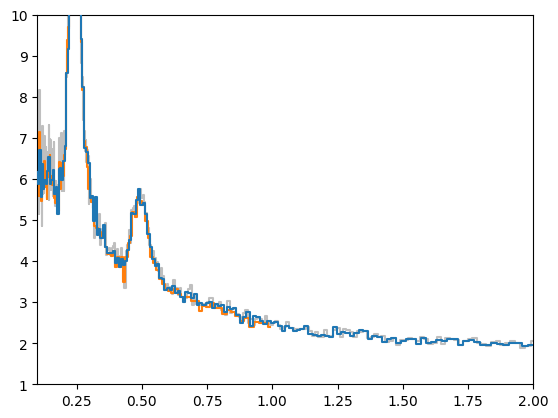

In [12]:
maxfreq = 1.
dt = 0.2 / maxfreq  # smaller than the Nyquist limit
ls = LombScarglePowerspectrum(ev_tot, dt=dt, max_freq=maxfreq, norm="leahy")
ls_reb = ls.rebin_log(0.02)

plt.plot(pds_dirty_reb.freq, pds_dirty_reb.power, alpha=0.5, ds="steps-mid", label="Powerspectrum, ignore gtis", color="grey")
plt.plot(pds_reb.freq, pds_reb.power, ds="steps-mid", label="AveragedPowerspectrum", zorder=10)
plt.plot(ls_reb.freq, ls_reb.power, ds="steps-mid", label="Lomb-Scargle periodogram")
plt.xlim([0.1, 2])
plt.ylim([1, 10])

# The Cross spectrum

A great new addition to Stingray is the Lomb-Scargle *cross* spectrum. The cross spectrum is the basis for many of the spectral-timing techniques that Stingray was born for (e.g. the covariance spectrum, time lags).  

Here we show a simple usage of the cross spectrum as a proxy for the (Poisson noise-subtracted) power density spectrum, using two datasets from two identical instruments onboard the same satellite.

Time lags measured with this cross spectrum make sense in our tests, only when the light curves are sampled at the same times. Also, we do not provide error bars on the time lags at the moment. Use with care!

258it [00:02, 107.72it/s]


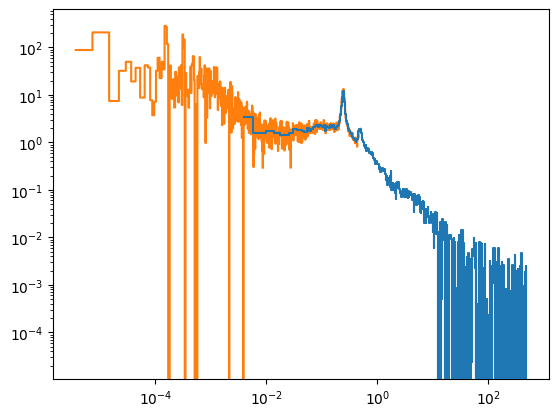

In [13]:
from stingray import LombScargleCrossspectrum
from stingray.gti import cross_two_gtis
gti = cross_two_gtis(ev1.gti, ev2.gti)
ev1.gti = gti
ev2.gti = gti
lscs = LombScargleCrossspectrum(ev1, ev2, dt=dt, norm="leahy")
lscs_reb = lscs.rebin_log(0.01)

cs = AveragedCrossspectrum(ev1, ev2, dt=0.001, segment_size=256, norm="leahy")
cs_reb = cs.rebin_log(0.02)

# plt.plot(pds_dirty_reb.freq, pds_dirty_reb.power, alpha=0.5, ds="steps-mid", label="Powerspectrum, ignore gtis", color="grey")
# plt.plot(pds_reb.freq, pds_reb.power, ds="steps-mid", label="AveragedPowerspectrum", zorder=10)
# plt.plot(ls_reb.freq, ls_reb.power, ds="steps-mid", label="Lomb-Scargle periodogram")
plt.plot(cs_reb.freq, cs_reb.power, ds="steps-mid", label="AveragedCrossspectrum", zorder=10)
plt.loglog()
good = lscs_reb.freq < maxfreq / 2
lscs_reb.freq = lscs_reb.freq[good]
lscs_reb.power = lscs_reb.power[good]
lscs_reb.unnorm_power = lscs_reb.unnorm_power[good]
plt.plot(lscs_reb.freq, lscs_reb.power, ds="steps-mid", label="Lomb-Scargle cross spectrum")
